<a href="https://colab.research.google.com/github/hamzaharmanhusni/Project-Dicoding/blob/main/NLP_Project_Dicoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import modul yang dibutuhkan

In [ ]:
#import pandas dan tensor flow
import tensorflow as tf
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import datetime
import random
import os

import nltk, os, re, string

from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

##Import Datasets

In [ ]:
# Import Data set yang akan digunakan
df = pd.read_csv('bbc-news-data.csv',sep='\t')

df.head()



,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [ ]:
df.shape

(2225, 4)

In [ ]:
df.info

<bound method DataFrame.info of       category filename                              title  \
0     business  001.txt  Ad sales boost Time Warner profit   
1     business  002.txt   Dollar gains on Greenspan speech   
2     business  003.txt  Yukos unit buyer faces loan claim   
3     business  004.txt  High fuel prices hit BA's profits   
4     business  005.txt  Pernod takeover talk lifts Domecq   
...        ...      ...                                ...   
2220      tech  397.txt   BT program to beat dialler scams   
2221      tech  398.txt    Spam e-mails tempt net shoppers   
2222      tech  399.txt            Be careful how you code   
2223      tech  400.txt    US cyber security chief resigns   
2224      tech  401.txt   Losing yourself in online gaming   

                                                content  
0      Quarterly profits at US media giant TimeWarne...  
1      The dollar has hit its highest level against ...  
2      The owners of embattled Russian oil giant 

In [ ]:
# Cek jumlah data yang dimiliki masing masing sentiment
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [ ]:
df.isnull().sum()

category    0
filename    0
title       0
content     0
dtype: int64

In [ ]:
#delete unused column

df = df.drop(columns = 'filename')

In [ ]:
# Banyak jumlah data sample
print(f"Total data training : {len(df)}")


Total data training : 2225


## Cleansing

In [ ]:
# function to clean the tweets
import re
import string
def cleanTxt(text):
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub('#', '', text)
    text = re.sub('RT[\s]+', '', text)
    text = re.sub('\w+:\/\/\S+', '', text)
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)
    #remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.strip()
    text = re.sub('<.*?>', ' ', text)
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub("\n", " ", text)
    text = re.sub(r"\b\w\b", " ", text)
    text = ' '.join(text.split())
    return text


In [ ]:
# removing functuation
def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
df['title'] = df['title'].apply(lambda x: cleaner(x))
df['content'] = df['content'].apply(lambda x: cleaner(x))

## lematization
lemmatizer = WordNetLemmatizer()

def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))
df['title'] = df['title'].apply(lambda x: lem(x))
df['content'] = df['content'].apply(lambda x: lem(x))

# removing number
def rem_numbers(data):
    return re.sub('[0-9]+','',data)
df['title'].apply(rem_numbers)
df['content'].apply(rem_numbers)

# removing stopword
st_words = set(stopwords.words('english'))
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))
df['title'] = df['title'].apply(lambda x: stopword(x))
df['content'] = df['content'].apply(lambda x: stopword(x))

## Gabung judul dan isi berita

In [ ]:
# MERGE JUDUL & ISI BERITA
df['merged_text'] = df['title'] + ' ' + df['content']

# DO PREPROCESSING
df['merged_text_pre'] = df['merged_text'].apply(cleanTxt)

In [ ]:
# view data after cleansing
df.head(10)

,category,title,content,merged_text,merged_text_pre
0,business,Ad sale boost Time Warner profit,Quarterly profit US medium giant TimeWarner ju...,Ad sale boost Time Warner profit Quarterly pro...,ad sale boost time warner profit quarterly pro...
1,business,Dollar gain Greenspan speech,The dollar ha hit highest level euro almost th...,Dollar gain Greenspan speech The dollar ha hit...,dollar gain greenspan speech the dollar ha hit...
2,business,Yukos unit buyer face loan claim,The owner embattled Russian oil giant Yukos as...,Yukos unit buyer face loan claim The owner emb...,yukos unit buyer face loan claim the owner emb...
3,business,High fuel price hit BAs profit,British Airways ha blamed high fuel price 40 d...,High fuel price hit BAs profit British Airways...,high fuel price hit bas profit british airways...
4,business,Pernod takeover talk lift Domecq,Shares UK drink food firm Allied Domecq risen ...,Pernod takeover talk lift Domecq Shares UK dri...,pernod takeover talk lift domecq shares uk dri...
5,business,Japan narrowly escape recession,Japans economy teetered brink technical recess...,Japan narrowly escape recession Japans economy...,japan narrowly escape recession japans economy...
6,business,Jobs growth still slow US,The US created fewer job expected January fall...,Jobs growth still slow US The US created fewer...,jobs growth still slow us the us created fewer...
7,business,India call fair trade rule,India attends G7 meeting seven leading industr...,India call fair trade rule India attends G7 me...,india call fair trade rule india attends meeti...
8,business,Ethiopias crop production 24,Ethiopia produced 1427 million tonne crop 2004...,Ethiopias crop production 24 Ethiopia produced...,ethiopias crop production ethiopia produced mi...
9,business,Court reject 280bn tobacco case,A US government claim accusing country biggest...,Court reject 280bn tobacco case A US governmen...,court reject bn tobacco case us government cla...


In [ ]:
# data category one-hot-encoding
category = pd.get_dummies(df.category)
df_cat = pd.concat([df, category], axis=1)
df_cat = df_cat.drop(columns='category')
df_cat.tail(10)

,title,content,merged_text,merged_text_pre,business,entertainment,politics,sport,tech
2215,Broadband fuel online expression,Fast web access encouraging people express onl...,Broadband fuel online expression Fast web acce...,broadband fuel online expression fast web acce...,0,0,0,0,1
2216,Savvy searcher fail spot ad,Internet search engine user odd mix naive soph...,Savvy searcher fail spot ad Internet search en...,savvy searcher fail spot ad internet search en...,0,0,0,0,1
2217,TVs future phone line,Internet TV ha talked since start web know But...,TVs future phone line Internet TV ha talked si...,tvs future phone line internet tv ha talked si...,0,0,0,0,1
2218,Cebit fever take Hanover,Thousands product ten thousand visitor make Ce...,Cebit fever take Hanover Thousands product ten...,cebit fever take hanover thousands product ten...,0,0,0,0,1
2219,New console promise big problem,Making game future console require graphic art...,New console promise big problem Making game fu...,new console promise big problem making game fu...,0,0,0,0,1
2220,BT program beat dialler scam,BT introducing two initiative help beat rogue ...,BT program beat dialler scam BT introducing tw...,bt program beat dialler scam bt introducing tw...,0,0,0,0,1
2221,Spam email tempt net shopper,Computer user across world continue ignore sec...,Spam email tempt net shopper Computer user acr...,spam email tempt net shopper computer user acr...,0,0,0,0,1
2222,Be careful code,A new European directive could put software wr...,Be careful code A new European directive could...,be careful code new european directive could p...,0,0,0,0,1
2223,US cyber security chief resigns,The man making sure US computer network safe s...,US cyber security chief resigns The man making...,us cyber security chief resigns the man making...,0,0,0,0,1
2224,Losing online gaming,Online role playing game timeconsuming enthral...,Losing online gaming Online role playing game ...,losing online gaming online role playing game ...,0,0,0,0,1


In [ ]:

# change dataframe value to numpy array
news = df_cat['merged_text_pre'].values
label = df_cat[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [ ]:
from sklearn.model_selection import train_test_split
data_latih, data_validasi, label_latih, label_validasi = train_test_split(news, label, test_size = 0.2)

data_latih.shape, label_latih.shape, data_validasi.shape, label_validasi.shape

((1780,), (1780, 5), (445,), (445, 5))

In [ ]:
import numpy as np
from collections import Counter

Counter(np.argmax(label_latih, axis=1))

Counter({0: 420, 2: 327, 3: 409, 1: 312, 4: 312})

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=123)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=10000, oov_token='<oov>')
tokenizer.fit_on_texts(data_latih)
tokenizer.fit_on_texts(data_validasi)


sekuens_latih = tokenizer.texts_to_sequences(data_latih)
sekuens_validasi = tokenizer.texts_to_sequences(data_validasi)

padded_latih = pad_sequences(sekuens_latih, padding = 'post', maxlen = 15, truncating ='post')
padded_validasi = pad_sequences(sekuens_validasi, padding = 'post', maxlen = 15, truncating ='post')

In [ ]:
# buat data menjadi balance
padded_latih, label_latih = sm.fit_resample(padded_latih, label_latih)

# cek label data latih
Counter(np.argmax(label_latih, axis=1))

Counter({0: 420, 2: 420, 3: 420, 1: 420, 4: 420})

## Pemodelan

In [ ]:
# model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
'''model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer= Adam(learning_rate = 0.001) , metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()'''

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 128)         1280000   
                                                                 
 lstm_6 (LSTM)               (None, 128)               131584    
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 5)                 165       
                                                                 
Total params: 1422085 (5.42 MB)
Trainable params: 1422

In [ ]:
#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.90):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 90%!")
callbacks = myCallback()

In [ ]:
# model fit
history = model.fit(padded_latih, label_latih, epochs=20,
                    validation_data=(padded_validasi, label_validasi), verbose=1,  callbacks=[callbacks], validation_steps=30)

Epoch 1/50


Exception ignored in: <function _xla_gc_callback at 0x7d7456866440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


66/66 [==============================] - 85s 66ms/step - loss: 1.5429 - accuracy: 0.3033 - val_loss: 1.1464 - val_accuracy: 0.6360
Epoch 2/50
66/66 [==============================] - 3s 41ms/step - loss: 0.8137 - accuracy: 0.7167 - val_loss: 0.4904 - val_accuracy: 0.8494
Epoch 3/50
66/66 [==============================] - 1s 12ms/step - loss: 0.2991 - accuracy: 0.9133 - val_loss: 0.5013 - val_accuracy: 0.8404
Epoch 4/50
66/66 [==============================] - 1s 14ms/step - loss: 0.1088 - accuracy: 0.9643 - val_loss: 0.9712 - val_accuracy: 0.8157
Epoch 5/50
66/66 [==============================] - 1s 17ms/step - loss: 0.1010 - accuracy: 0.9719 - val_loss: 0.6626 - val_accuracy: 0.8494
Epoch 6/50
66/66 [==============================] - 1s 16ms/step - loss: 0.0822 - accuracy: 0.9795 - val_loss: 0.6572 - val_accuracy: 0.8449
Epoch 7/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0476 - accuracy: 0.9881 - val_loss: 0.9316 - val_accuracy: 0.8449
Epoch 8/50
66/66 [=====

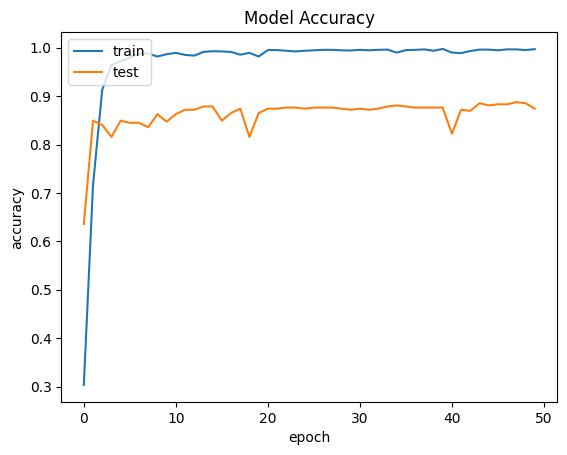

In [ ]:

# plot of accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

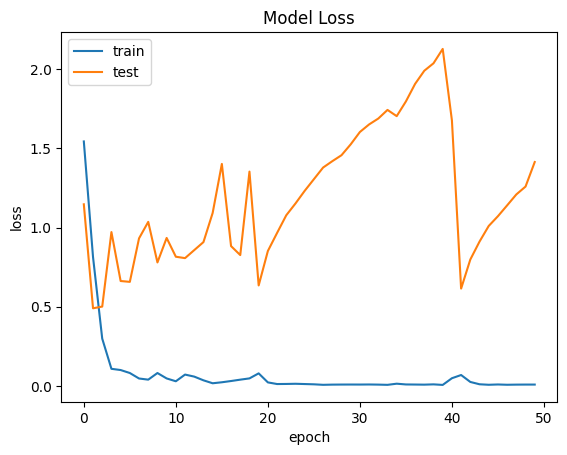

In [ ]:

# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()